# Deep Learning RNN Model for Used Motorcycle Price Prediction
## IS794 AL - Deep Learning (Lab)
Kelompok B: <br>
- Daffa Kaisha Pratama Chandra (00000055770)
- Justine Donovan (00000063202)
- Marsella Patricia (00000063226)
- Reina Ratu Balqis (00000065099)
---
### Import Libraries

In [22]:
# Basic library
import pandas as pd
import numpy as np
from scipy import stats

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Deep learning
import tensorflow as tf
from tensorflow import keras

# Ignore warning
import warnings
warnings.simplefilter("ignore")

---
Baca Dataset

In [23]:
yamaha = pd.read_csv("motor_yamaha_bekas.csv", index_col=False)
honda = pd.read_csv("motor_honda_bekas.csv", index_col=False)
kawasaki = pd.read_csv("motor_kawasaki_bekas.csv", index_col=False)
suzuki = pd.read_csv("motor_suzuki_bekas.csv", index_col=False)

Penjelasan singkat mengenai dataset yang digunakan: <br>
Dataset ini merupakan hasil web scraping dari website https://momotor.id/

In [24]:
print("Shape dari tiap dataset:")
print(f"Dataset Yamaha memiliki {yamaha.shape[1]} kolom dan {yamaha.shape[0]} baris.")
print(f"Dataset Honda memiliki {honda.shape[1]} kolom dan {honda.shape[0]} baris.")
print(f"Dataset Kawasaki memiliki {kawasaki.shape[1]} kolom dan {kawasaki.shape[0]} baris.")
print(f"Dataset Suzuki memiliki {suzuki.shape[1]} kolom dan {suzuki.shape[0]} baris.")

Shape dari tiap dataset:
Dataset Yamaha memiliki 10 kolom dan 588 baris.
Dataset Honda memiliki 10 kolom dan 1008 baris.
Dataset Kawasaki memiliki 10 kolom dan 348 baris.
Dataset Suzuki memiliki 10 kolom dan 348 baris.


In [25]:
print("Informasi singkat dari tiap dataset:\n")
print("Yamaha:")
print(yamaha.info())
print("\nHonda:")
print(honda.info())
print("\nKawasaki:")
print(kawasaki.info())
print("\nSuzuki:")
print(suzuki.info())

Informasi singkat dari tiap dataset:

Yamaha:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_motor       343 non-null    object 
 1   lokasi           343 non-null    object 
 2   harga            343 non-null    object 
 3   deskripsi        343 non-null    object 
 4   kapasitas_mesin  343 non-null    object 
 5   tahun            343 non-null    float64
 6   transmisi        343 non-null    object 
 7   kilometer        343 non-null    object 
 8   url              588 non-null    object 
 9   merk             588 non-null    object 
dtypes: float64(1), object(9)
memory usage: 46.1+ KB
None

Honda:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_motor       756 non-nu

Pre-process I: Data mentah -> Data siap pakai
Akan dilakukan cek <i> missing values. </i> Jika terdapat <i> missing values, </i> data yang hilang akan diimputasi menggunakan nilai modus. 

In [26]:
# Cek rata-rata missing values pada tiap dataset
brand = ['yamaha', 'honda', 'kawasaki', 'suzuki']
data = [yamaha, honda, kawasaki, suzuki]

for i, j in zip(brand, data):
    print(f"{i} missing values: \n{np.round(honda.isnull().mean(), 2)*100}")
    print()

yamaha missing values: 
nama_motor         25.0
lokasi             25.0
harga              25.0
deskripsi          25.0
kapasitas_mesin    25.0
tahun              25.0
transmisi          25.0
kilometer          25.0
url                 0.0
merk                0.0
dtype: float64

honda missing values: 
nama_motor         25.0
lokasi             25.0
harga              25.0
deskripsi          25.0
kapasitas_mesin    25.0
tahun              25.0
transmisi          25.0
kilometer          25.0
url                 0.0
merk                0.0
dtype: float64

kawasaki missing values: 
nama_motor         25.0
lokasi             25.0
harga              25.0
deskripsi          25.0
kapasitas_mesin    25.0
tahun              25.0
transmisi          25.0
kilometer          25.0
url                 0.0
merk                0.0
dtype: float64

suzuki missing values: 
nama_motor         25.0
lokasi             25.0
harga              25.0
deskripsi          25.0
kapasitas_mesin    25.0
tahun          

In [27]:
# cari modus dari tiap kolom yang terdapat missing values
kolom_null = ['nama_motor', 'lokasi', 'harga', 'deskripsi', 
              'kapasitas_mesin', 'tahun', 'transmisi', 'kilometer']

In [28]:
# Cari modus dan replace NaN dengan modus
for col in kolom_null:
    # Yamaha
    modus_yamaha = yamaha[col].mode()[0]
    yamaha[col] = yamaha[col].fillna(modus_yamaha)
    
    #Honda
    modus_honda = honda[col].mode()[0]
    honda[col] = honda[col].fillna(modus_honda)
    
    #Kawasaki
    modus_kawasaki = kawasaki[col].mode()[0]
    kawasaki[col] = kawasaki[col].fillna(modus_kawasaki)
    
    #Honda
    modus_suzuki = suzuki[col].mode()[0]
    suzuki[col] = suzuki[col].fillna(modus_suzuki)

In [29]:
# Cek missing values lagi
for i, j in zip(brand, data):
    print(f"{i} missing values: \n{np.round(honda.isnull().mean(), 2)*100}")
    print()

yamaha missing values: 
nama_motor         0.0
lokasi             0.0
harga              0.0
deskripsi          0.0
kapasitas_mesin    0.0
tahun              0.0
transmisi          0.0
kilometer          0.0
url                0.0
merk               0.0
dtype: float64

honda missing values: 
nama_motor         0.0
lokasi             0.0
harga              0.0
deskripsi          0.0
kapasitas_mesin    0.0
tahun              0.0
transmisi          0.0
kilometer          0.0
url                0.0
merk               0.0
dtype: float64

kawasaki missing values: 
nama_motor         0.0
lokasi             0.0
harga              0.0
deskripsi          0.0
kapasitas_mesin    0.0
tahun              0.0
transmisi          0.0
kilometer          0.0
url                0.0
merk               0.0
dtype: float64

suzuki missing values: 
nama_motor         0.0
lokasi             0.0
harga              0.0
deskripsi          0.0
kapasitas_mesin    0.0
tahun              0.0
transmisi          0.0
kilo

In [30]:
# Merge dataset
used_motor = pd.concat([yamaha, honda, kawasaki, suzuki])
print("Shape dari dataset yang digabung: ", used_motor.shape)
used_motor.head()

Shape dari dataset yang digabung:  (2292, 10)


,nama_motor,lokasi,harga,deskripsi,kapasitas_mesin,tahun,transmisi,kilometer,url,merk
0,Yamaha All New Nmax 155,Kota Medan,"Rp17,500,000","Ss lengkap , plat pajak hidup , nego di tempat",125 CC,2019.0,Otomatis,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha
1,Yamaha All New Nmax 155,Kota Medan,"Rp17,500,000","Ss lengkap , plat pajak hidup , nego di tempat",125 CC,2019.0,Otomatis,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha
2,Yamaha All New Nmax 155,Kota Medan,"Rp17,500,000","Ss lengkap , plat pajak hidup , nego di tempat",125 CC,2019.0,Otomatis,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha
3,Yamaha All New Nmax 155,Kota Medan,"Rp17,500,000","Ss lengkap , plat pajak hidup , nego di tempat",125 CC,2019.0,Otomatis,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha
4,Yamaha All New Nmax 155,Kota Medan,"Rp17,500,000","Ss lengkap , plat pajak hidup , nego di tempat",125 CC,2019.0,Otomatis,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha


---
#### Exploratory Data Analysis <br>
Pada tahap EDA, akan dilakukan ....

In [31]:
used_motor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2292 entries, 0 to 347
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_motor       2292 non-null   object 
 1   lokasi           2292 non-null   object 
 2   harga            2292 non-null   object 
 3   deskripsi        2292 non-null   object 
 4   kapasitas_mesin  2292 non-null   object 
 5   tahun            2292 non-null   float64
 6   transmisi        2292 non-null   object 
 7   kilometer        2292 non-null   object 
 8   url              2292 non-null   object 
 9   merk             2292 non-null   object 
dtypes: float64(1), object(9)
memory usage: 197.0+ KB


In [32]:
# Loop melalui tiap kolom dan mencetak nilai unik
unique_value_count ={}
for column in used_motor.columns : 
    unique_values = used_motor[column].unique()
    unique_count = len(unique_values)
    unique_value_count[column] = unique_count

for column, count in unique_value_count.items():
    print(f"{column} : {count}")


nama_motor : 22
lokasi : 9
harga : 22
deskripsi : 21
kapasitas_mesin : 7
tahun : 6
transmisi : 2
kilometer : 4
url : 48
merk : 4


In [33]:
# Melihat Unique Values pada tiap variabel
for kolom in used_motor.columns:
    unique_values = used_motor[kolom].unique()
    print(f"Kolom {kolom}: {unique_values}")

Kolom nama_motor: ['Yamaha All New Nmax 155' 'Yamaha Lexi S' 'Yamaha Jupiter Mx Cw'
 'Yamaha Nmax Abs' 'Yamaha Fino Sporty' 'Yamaha Gear 125'
 'Yamaha Gear 125 S-version' 'Honda Vario 125 Esp Cbs Iss'
 'Honda Beat Esp Cbs Iss Dlx' 'Honda New Beat Street Esp' 'Honda Cb150r'
 'Honda Supra X 125 Injeksi' 'Kawasaki Klx 150' 'Kawasaki Ninja 250'
 'Kawasaki Ninja 250 Abs Se' 'Kawasaki Ninja R' 'Kawasaki Z 800'
 'Kawasaki Ninja Rr' 'Suzuki Gsx R150' 'Suzuki Satria Fu 150'
 'Suzuki Gsx 150 Bandit' 'Suzuki Satria F 150']
Kolom lokasi: ['Kota Medan' 'Kota Bekasi' 'Kota Jakarta Barat' 'Kab. Tangerang'
 'Kota Jakarta Timur' 'Kab. Bandung' 'Kota Jakarta Selatan' 'Kota Bandung'
 'Kota Jakarta Utara']
Kolom harga: ['Rp17,500,000' 'Rp17,800,000' 'Rp12,500,000' 'Rp27,300,000'
 'Rp14,800,000' 'Rp20,800,000' 'Rp18,600,000' 'Rp17,600,000'
 'Rp18,500,000' 'Rp24,999,000' 'Rp16,000,000' 'Rp21,500,000'
 'Rp22,900,000' 'Rp24,500,000' 'Rp37,000,000' 'Rp52,400,000'
 'Rp246,000,000' 'Rp34,500,000' 'Rp16,900,000' 

---
#### Data Pre-processing
Pada tahap ini, akan dilakukan:
- <i>remove missing values</i>
- 

##### Membersihkan kolom harga

In [34]:
def clean_harga(harga):
    harga_clean = harga.replace("Rp", "").replace(".", "").replace(",", "")
    return harga_clean

used_motor['harga'] = used_motor['harga'].apply(clean_harga)
# used_motor['harga'] = pd.to_numeric(used_motor['harga'], errors='coerce', downcast='integer')
# used_motor['harga'] = pd.to_numeric(used_motor['harga'], errors='coerce')
used_motor['harga'] = used_motor['harga'].apply(float)

##### Membersihkan kolom kapasitas mesin

In [35]:
def clean_cc(kapasitas_mesin):
    cc_clean = kapasitas_mesin.replace("cc", "")
    return cc_clean

used_motor['kapasitas_mesin'] = used_motor['kapasitas_mesin'].apply(clean_cc)

##### Membuat kategori baru untuk kolom kilometer

In [36]:
used_motor['kilometer_kategori'] = used_motor['kilometer'].replace({'>30000 KM': 'Tinggi', '5000 - 10000KM': 'Sedang', '10000 - 20000KM': 'Sedang', '1000 - 5000 KM': 'Rendah'})

In [37]:
used_motor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2292 entries, 0 to 347
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama_motor          2292 non-null   object 
 1   lokasi              2292 non-null   object 
 2   harga               2292 non-null   float64
 3   deskripsi           2292 non-null   object 
 4   kapasitas_mesin     2292 non-null   object 
 5   tahun               2292 non-null   float64
 6   transmisi           2292 non-null   object 
 7   kilometer           2292 non-null   object 
 8   url                 2292 non-null   object 
 9   merk                2292 non-null   object 
 10  kilometer_kategori  2292 non-null   object 
dtypes: float64(2), object(9)
memory usage: 214.9+ KB


##### Encoding

In [40]:
# Initialize LabelEncoder
le = LabelEncoder()

# Select column wiht categorical values
cols = ['nama_motor', 'lokasi', 'kapasitas_mesin', 'tahun', 'transmisi', 'kilometer_kategori', 'merk']
for i in cols:
    used_motor[i] = le.fit_transform(used_motor[i]) + 1

# Check the data
used_motor.head()

,nama_motor,lokasi,harga,deskripsi,kapasitas_mesin,tahun,transmisi,kilometer,url,merk,kilometer_kategori
0,16,9,17500000.0,"Ss lengkap , plat pajak hidup , nego di tempat",2,4,2,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,4,3
1,16,9,17500000.0,"Ss lengkap , plat pajak hidup , nego di tempat",2,4,2,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,4,3
2,16,9,17500000.0,"Ss lengkap , plat pajak hidup , nego di tempat",2,4,2,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,4,3
3,16,9,17500000.0,"Ss lengkap , plat pajak hidup , nego di tempat",2,4,2,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,4,3
4,16,9,17500000.0,"Ss lengkap , plat pajak hidup , nego di tempat",2,4,2,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,4,3


##### Drop variabel yang tidak dibutuhkan

In [43]:
used_motor = used_motor.drop(columns=['kilometer', 'deskripsi', 'url'])
used_motor.head()

,nama_motor,lokasi,harga,kapasitas_mesin,tahun,transmisi,merk,kilometer_kategori
0,16,9,17500000.0,2,4,2,4,3
1,16,9,17500000.0,2,4,2,4,3
2,16,9,17500000.0,2,4,2,4,3
3,16,9,17500000.0,2,4,2,4,3
4,16,9,17500000.0,2,4,2,4,3


##### MinMax Scaler

In [44]:
# Initialize MinMaxScaler
mms = MinMaxScaler()

# Normalisasi
standard = mms.fit_transform(used_motor)

# Save the Normalize result to dataframe
used_motor = pd.DataFrame(standard, columns=used_motor.columns)

# See the data
used_motor.head()

,nama_motor,lokasi,harga,kapasitas_mesin,tahun,transmisi,merk,kilometer_kategori
0,0.714286,1.0,0.029724,0.2,0.6,1.0,1.0,1.0
1,0.714286,1.0,0.029724,0.2,0.6,1.0,1.0,1.0
2,0.714286,1.0,0.029724,0.2,0.6,1.0,1.0,1.0
3,0.714286,1.0,0.029724,0.2,0.6,1.0,1.0,1.0
4,0.714286,1.0,0.029724,0.2,0.6,1.0,1.0,1.0


##### confussion Matrix

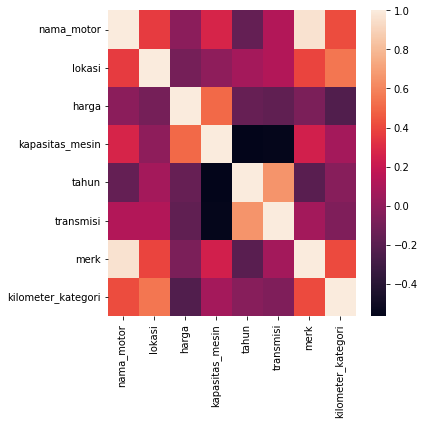

In [49]:
correlation = used_motor.corr()

plt.figure(figsize=(6,6))
sns.heatmap(correlation)
plt.tight_layout()
plt.show()

##### Feature Selection

In [45]:
# Choosing X and y
X = used_motor.drop(columns='harga')
y = used_motor['harga']

In [46]:
# Train test split untuk feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Random forest regressor untuk memilih feature importance
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


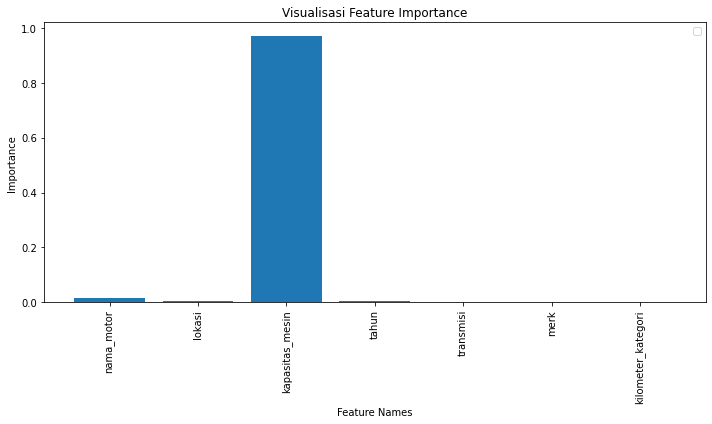

In [48]:
rf_fi = rf.feature_importances_

# Define Nama columns
feature_names = X_train.columns.tolist()

plt.figure(figsize=(10, 6))

# Plotting feature importances
plt.bar(feature_names, rf_fi)
plt.xticks(rotation='vertical')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.title('Visualisasi Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()

---
#### Modeling
Pada tahap ....

Tuning Hyperparameter <br>
....

Finalisasi Model
....

---
#### Evaluasi

Terlihat model .....

---
#### Save model
Model yang dengan akurasi tertinggi akan disimpan untuk di <i> deploy </i>